[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/07_Tutorial_Reinforce_Maze_NeuralNetwork_Jax.ipynb)

# Tutorial on Using REINFORCE (Basic Policy Gradient) to Solve the MAZE Problem

## Basic Theory of REINFORCE Algorithm

The REINFORCE algorithm is a fundamental policy gradient method used in reinforcement learning. It aims to optimize a policy by directly estimating the gradient of the expected reward with respect to the policy parameters. 

The goal of reinforcement learning is to find a policy $\pi_\theta(a|s)$ that maximizes the expected cumulative reward, known as the return $R_t$, over time:
   $$
   R_t = \sum_{k=0}^\infty \gamma^k r_{t+k}
   $$
   where, 
- $s$ (state):The current situation or configuration of the environment.
- $a$ (action): A decision made by the agent that affects the state.
- $r$ (reward): Feedback from the environment indicating the result of an action.
- $\pi$ (policy): A function parameterized by $\theta$ that maps states to a probability distribution over actions.
- $\gamma$ is the discount factor, $0 \leq \gamma \leq 1$.


The gradient of the expected return with respect to the policy parameters $\theta$ is given by:
   $$
   \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) R_t \right]
   $$
   where $J(\theta)$ is the expected return under the policy $\pi_\theta$.

Using the policy gradient, the parameters $\theta$ are updated as follows:
   $$
   \theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)
   $$
   where $\alpha$ is the learning rate.



# Importing necessary libraries

In [1]:
import jax 
import jax.numpy as jnp  
import numpy as np  
import matplotlib.pyplot as plt  
import optax  # A gradient processing and optimization library for JAX.
import flax.linen as nn  # Flax's neural network library built on JAX for building and training neural networks.
from flax.training import train_state  # Utility from Flax to manage the state of the model during training.
import random  
import imageio.v2 as imageio  
from tqdm import tqdm 
import os  


# Function to generate a maze using a randomized Prim's algorithm

In [2]:
def generate_maze(width=11, height=11, complexity=0.75, density=0.75):
    # Define the shape of the maze ensuring it has odd dimensions
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Define the complexity and density of the maze based on given parameters
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Initialize the maze with all walls
    Z = np.zeros(shape, dtype=bool)
    # Set the borders to be walls
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    for i in range(density):
        # Choose a random position and set it as a wall
        x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            # Check for valid neighbours
            if x > 1:
                neighbours.append((y, x - 2))
            if x < shape[1] - 2:
                neighbours.append((y, x + 2))
            if y > 1:
                neighbours.append((y - 2, x))
            if y < shape[0] - 2:
                neighbours.append((y + 2, x))
            if len(neighbours):
                # Randomly select a neighbour
                y_, x_ = neighbours[np.random.randint(0, len(neighbours))]
                if Z[y_, x_] == 0:
                    # Create a path between the cells
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z

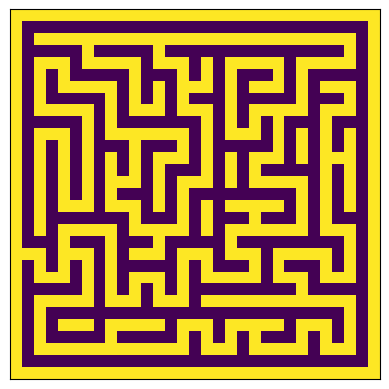

In [3]:
# visualize
plt.imshow(generate_maze(width=31,height=31))
plt.xticks([])
plt.yticks([])
plt.show()

# Maze environment class (no batches)

In [4]:
class MazeEnv:
    def __init__(self, width=9, height=9, num_chests=10, num_steps=30):
        self.width = width  # Width of the maze
        self.height = height  # Height of the maze
        self.num_chests = num_chests  # Number of treasure chests
        self.world = jnp.array(generate_maze(width, height), dtype=jnp.int32)  # Generate the maze
        self.reward_map = jnp.zeros((width, height))  # Initialize reward map
        self._place_treasure_chests()  # Place treasure chests in the maze
        self.reward_map_init = self.reward_map  # Save initial reward map state
        self.state = None  # Initialize the state
        self.num_steps = num_steps  # Maximum number of steps allowed
        self.reset()  # Reset the environment

    # Place treasure chests randomly in the maze
    def _place_treasure_chests(self):
        for _ in range(self.num_chests):
            while True:
                # Randomly choose a position for the chest
                jx, jy = np.random.randint(self.width), np.random.randint(self.height)
                # Ensure the position is valid (not a wall and not too close to the start)
                if self.world[jx, jy] == 0 and (jx > 2 or jy > 2):
                    self.reward_map = self.reward_map.at[jx, jy].set(1)  # Place the chest
                    break

    # Reset the environment
    def reset(self):
        self.timestep = 0  # Reset timestep counter
        self.state = jnp.zeros((self.width, self.height), dtype=jnp.float32)  # Reset state
        self.current_position = (1, 1)  # Start position
        self.state = self.state.at[1, 1].set(1)  # Mark the start position in the state
        self.reward_map = self.reward_map_init  # Reset the reward map
        return self.state  # Return the initial state

    # Take a step in the environment
    def step(self, action):
        self.timestep += 1  # Increment the timestep
        directions = jnp.array([[0, 1], [0, -1], [1, 0], [-1, 0]])  # Define possible directions
        jx, jy = self.current_position  # Get current position
        # Calculate new position based on the action
        jx_new, jy_new = jnp.array([jx, jy]) + directions[action]

        if self.world[jx_new, jy_new] == 0:
            # If the new position is not a wall, move to the new position
            self.current_position = (jx_new, jy_new)
            reward = 10.0 * self.reward_map[jx_new, jy_new]  # Get reward if there's a chest
        else:
            reward = -1.0  # Penalize hitting a wall

        done = self.timestep == self.num_steps  # Check if maximum steps are reached

        self.state = jnp.zeros((self.width, self.height), dtype=jnp.float32)  # Reset the state
        jx, jy = self.current_position  # Get current position
        self.state = self.state.at[jx, jy].set(1)  # Mark current position in the state
        self.reward_map = self.reward_map.at[jx, jy].set(0)  # Remove the chest if collected

        return self.state, reward, done  # Return the new state, reward, and done flag

    # Render the environment
    def render(self, save_path=None):
        plt.imshow(self.world, alpha=1, cmap='gray')  # Display the maze
        plt.xticks([])  # Hide x-axis ticks
        plt.yticks([])  # Hide y-axis ticks
        plt.imshow(self.reward_map, alpha=0.7, cmap='jet')  # Display the reward map
        plt.imshow(self.state, alpha=0.5, cmap='hot')  # Display the current state
        if save_path:
            plt.savefig(save_path)  # Save the image if a path is provided
            plt.close()  # Close the plot
        else:
            plt.show()  # Otherwise, show the plot

# Define the policy network using Flax
class PolicyNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(128)(x))  # First dense layer with ReLU activation
        # x = nn.relu(nn.Dense(32)(x))  # Second dense layer with ReLU activation
        x = nn.Dense(4)(x)  # Output layer with 4 actions
        return nn.log_softmax(x)  # Log-softmax activation for output

# Create the training state for the policy network
def create_train_state(key, learning_rate, input_shape):
    policy_net = PolicyNetwork()  # Initialize the policy network
    params = policy_net.init(key, jnp.ones(input_shape))['params']  # Initialize parameters
    tx = optax.adam(learning_rate)  # Define the optimizer
    return train_state.TrainState.create(apply_fn=policy_net.apply, params=params, tx=tx)  # Create the training state

# Select an action based on the policy network
@jax.jit
def select_action(params, state, key):
    logits = PolicyNetwork().apply({'params': params}, state)  # Compute the action logits
    return jax.random.categorical(key, logits)  # Sample an action based on the logits

# Compute the loss for the policy network
@jax.jit
def compute_loss(params, states, actions, rewards):
    def policy_loss(logits, actions, rewards):
        log_probs = jax.nn.log_softmax(logits)  # Compute log probabilities
        selected_log_probs = jnp.sum(log_probs * jax.nn.one_hot(actions, logits.shape[-1]), axis=-1)  # Get selected log probabilities
        return -jnp.mean(selected_log_probs * rewards)  # Compute the loss

    logits = PolicyNetwork().apply({'params': params}, states)  # Get logits for the states
    return policy_loss(logits, actions, rewards)  # Compute the policy loss

# Update the model parameters based on the gradients
@jax.jit
def update_model(state, states, actions, rewards):
    grads = jax.grad(compute_loss)(state.params, states, actions, rewards)  # Compute the gradients
    return state.apply_gradients(grads=grads)  # Apply the gradients to update the model

# Discount the rewards for each episode
def discount_rewards(rewards, gamma=1.0):
    discounted_rewards = np.zeros_like(rewards)  # Initialize discounted rewards array
    cumulative_rewards = 0  # Initialize cumulative rewards
    for i in reversed(range(len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]  # Compute discounted rewards
        discounted_rewards[i] = cumulative_rewards  # Store the discounted reward
    return discounted_rewards

## Train the model

In [5]:
def train(env, state, num_episodes=300, gamma=1.0, save_interval=50):
    returns = []  # List to store returns of each episode
    saved_actions = []  # List to store actions for creating GIF

    pbar = tqdm(range(num_episodes))  # Progress bar for tracking training
    for episode in pbar:
        episode_states, episode_actions, episode_rewards = [], [], []  # Lists to store states, actions, and rewards for the episode
        state_np = np.array(env.reset()).flatten()  # Flatten the initial state
        done = False  # Initialize done flag
        episode_reward = 0  # Initialize episode reward

        while not done:
            key = jax.random.PRNGKey(random.randint(0, int(1e9)))  # Generate a random key for action selection
            action = select_action(state.params, jnp.array([state_np]), key)  # Select an action
            action = int(action[0])  # Convert action to integer
            next_state, reward, done = env.step(action)  # Take a step in the environment
            next_state = next_state.flatten()  # Flatten the next state

            episode_states.append(state_np)  # Store the current state
            episode_actions.append(action)  # Store the action
            episode_rewards.append(reward)  # Store the reward

            state_np = np.array(next_state)  # Update the current state
            episode_reward += reward  # Accumulate the reward

        returns.append(episode_reward)  # Store the total reward of the episode

        if episode % save_interval == 0:
            saved_actions.append(episode_actions)  # Save actions for creating GIF

        episode_states = jnp.array(episode_states)  # Convert states to JAX array
        episode_actions = jnp.array(episode_actions)  # Convert actions to JAX array
        episode_rewards = discount_rewards(np.array(episode_rewards), gamma)  # Discount rewards
        episode_rewards = jnp.array(episode_rewards)  # Convert rewards to JAX array

        state = update_model(state, episode_states, episode_actions, episode_rewards)  # Update the model

        pbar.set_description(f'Episode {episode+1}: Reward = {episode_reward}')  # Update progress bar description
    return state, returns, saved_actions  # Return the trained state, returns, and saved actions

# Initialize the environment
env = MazeEnv(width=9, height=9, num_chests=10, num_steps=100)  # Create a MazeEnv instance

# Initialize the network
key = jax.random.PRNGKey(0)  # Generate a random key for parameter initialization
input_shape = (1, env.width * env.height)  # Define the input shape for the network
state = create_train_state(key, learning_rate=0.01, input_shape=input_shape)  # Create the training state

# Train the model
trained_state, returns, saved_actions = train(env, state, num_episodes=500)  # Train the policy network


Episode 500: Reward = 63.0: 100%|██████████| 500/500 [01:02<00:00,  8.01it/s] 


## Plot the returns

Text(0.5, 1.0, 'Maze Environment Learning Curve')

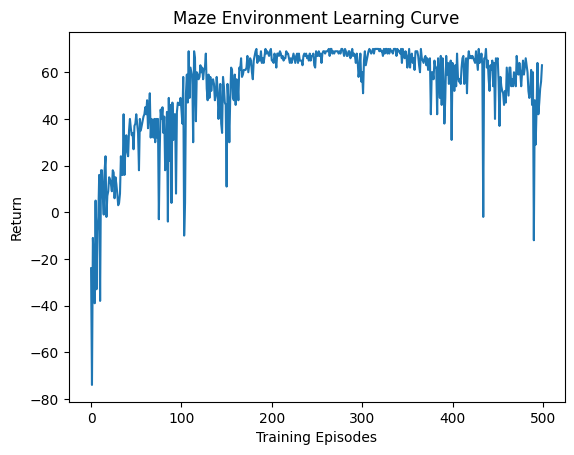

In [6]:
plt.plot(jnp.stack(returns))
plt.xlabel("Training Episodes")
plt.ylabel("Return")
plt.title("Maze Environment Learning Curve")

## Check the reward map

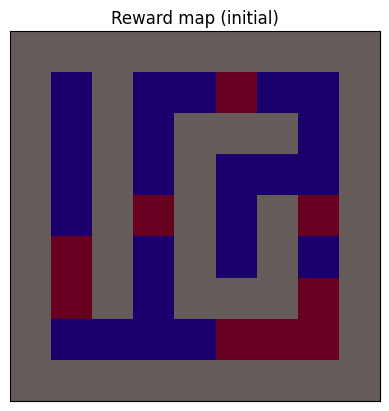

In [7]:
plt.imshow(env.world)
plt.imshow(env.reward_map_init, alpha=0.6, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.title("Reward map (initial)")
plt.show()

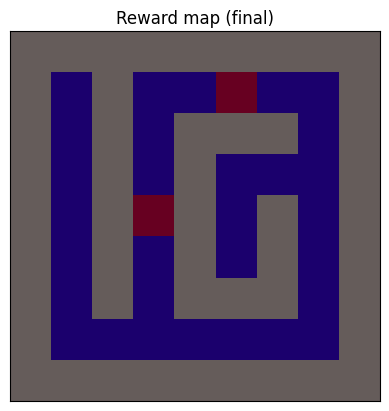

In [8]:
plt.imshow(env.world)
plt.imshow(env.reward_map, alpha=0.6, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.title("Reward map (final)")
plt.show()

## Create a GIF from the saved actions

In [9]:
def create_gif_from_actions(env, saved_actions, save_path='training_reinforce.gif'):
    frames = []  # List to store frames for the GIF
    for actions in saved_actions:
        state = env.reset()  # Reset the environment
        for action in actions:
            state, _, _ = env.step(action)  # Take a step in the environment
            fig_path = 'frame.png'  # Path to save the frame
            env.render(save_path=fig_path)  # Render the environment and save the frame
            frames.append(imageio.imread(fig_path))  # Read the frame and add to the list
            os.remove(fig_path)  # Remove the saved frame
    imageio.mimsave(save_path, frames, fps=10)  # Save the frames as a GIF

# create_gif_from_actions(env, saved_actions, save_path='training_reinforce.gif')


# Batched maze environment class

In [10]:
class BatchedMazeEnv:
    def __init__(self, width=9, height=9, num_chests=10, num_steps=50, batch_size=32):
        self.width = width  # Width of the maze
        self.height = height  # Height of the maze
        self.num_chests = num_chests  # Number of treasure chests
        self.num_steps = num_steps  # Maximum number of steps allowed
        self.batch_size = batch_size  # Batch size for parallel environments

        self.world = jnp.array(generate_maze(width, height), dtype=jnp.int32)  # Generate the maze
        self.reward_map = jnp.zeros((width, height))  # Initialize reward map
        self._place_treasure_chests()  # Place treasure chests in the maze

        self.reward_map_init = self.reward_map  # Save initial reward map state
        self.reset()  # Reset the environment

    # Place treasure chests randomly in the maze
    def _place_treasure_chests(self):
        for _ in range(self.num_chests):
            while True:
                jx, jy = np.random.randint(self.width), np.random.randint(self.height)  # Randomly choose a position for the chest
                if self.world[jx, jy] == 0 and (jx > 2 or jy > 2):  # Ensure the position is valid (not a wall and not too close to the start)
                    self.reward_map = self.reward_map.at[jx, jy].set(1)  # Place the chest
                    break

    # Reset the environment
    def reset(self):
        self.timesteps = jnp.zeros(self.batch_size, dtype=int)  # Reset timestep counters
        self.states = jnp.zeros((self.batch_size, self.width, self.height), dtype=jnp.float32)  # Reset states
        self.current_positions = jnp.ones((self.batch_size, 2), dtype=int)  # Start positions for all environments
        self.states = self.states.at[:, 1, 1].set(1)  # Mark the start positions in the states
        self.reward_maps = jnp.tile(self.reward_map, (self.batch_size, 1, 1))  # Initialize reward maps for all environments
        return self.states  # Return the initial states

    # Take a step in the environment
    def step(self, actions):
        directions = jnp.array([[0, 1], [0, -1], [1, 0], [-1, 0]])  # Define possible directions
        new_positions = self.current_positions + directions[actions]  # Calculate new positions based on the actions
        new_positions = jnp.clip(new_positions, 0, self.width - 1)  # Clip new positions to stay within the maze bounds

        # Calculate rewards based on the new positions
        rewards = jnp.where(
            self.world[new_positions[:, 0], new_positions[:, 1]] == 0,
            10 * self.reward_maps[jnp.arange(self.batch_size), new_positions[:, 0], new_positions[:, 1]],
            -1
        )

        self.timesteps += 1  # Increment the timestep counters
        dones = self.timesteps >= self.num_steps  # Check if maximum steps are reached for each environment

        # Determine if the moves are valid (not hitting a wall)
        valid_moves = self.world[new_positions[:, 0], new_positions[:, 1]] == 0
        self.current_positions = jnp.where(valid_moves[:, None], new_positions, self.current_positions)  # Update positions if moves are valid

        self.states = jnp.zeros((self.batch_size, self.width, self.height), dtype=jnp.float32)  # Reset the states
        self.states = self.states.at[jnp.arange(self.batch_size), self.current_positions[:, 0], self.current_positions[:, 1]].set(1)  # Mark current positions in the states
        self.reward_maps = self.reward_maps.at[jnp.arange(self.batch_size), self.current_positions[:, 0], self.current_positions[:, 1]].set(0)  # Remove chests if collected

        return self.states, rewards, dones  # Return the new states, rewards, and done flags

    # Render the environment
    def render(self, save_path=None, index=0):
        plt.imshow(self.world, alpha=1)  # Display the maze
        plt.xticks([])  # Hide x-axis ticks
        plt.yticks([])  # Hide y-axis ticks
        plt.imshow(self.reward_maps[index], alpha=0.7, cmap='jet')  # Display the reward map for the specified environment
        plt.imshow(self.states[index], alpha=0.5, cmap='hot')  # Display the current state for the specified environment
        if save_path:
            plt.savefig(f"{save_path}_{index}.png")  # Save the image if a path is provided
            plt.close()  # Close the plot
        else:
            plt.show()  # Otherwise, show the plot

## Define the policy network using Flax

In [11]:
class PolicyNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(128)(x))  # First dense layer with ReLU activation
        # x = nn.relu(nn.Dense(64)(x))  # Second dense layer with ReLU activation
        x = nn.Dense(4)(x)  # Output layer with 4 actions
        return nn.log_softmax(x)  # Log-softmax activation for output

# Create the training state for the policy network
def create_train_state(key, learning_rate, input_shape):
    policy_net = PolicyNetwork()  # Initialize the policy network
    params = policy_net.init(key, jnp.ones(input_shape))['params']  # Initialize parameters
    tx = optax.adam(learning_rate)  # Define the optimizer
    return train_state.TrainState.create(apply_fn=policy_net.apply, params=params, tx=tx)  # Create the training state

# Select an action based on the policy network
@jax.jit
def select_action(params, state, key):
    logits = PolicyNetwork().apply({'params': params}, state)  # Compute the action logits
    return jax.random.categorical(key, logits)  # Sample an action based on the logits

# Compute the loss for the policy network
@jax.jit
def compute_loss(params, states, actions, rewards):
    def policy_loss(logits, actions, rewards):
        log_probs = jax.nn.log_softmax(logits)  # Compute log probabilities
        selected_log_probs = jnp.sum(log_probs * jax.nn.one_hot(actions, logits.shape[-1]), axis=-1)  # Get selected log probabilities
        return -jnp.mean(selected_log_probs * rewards)  # Compute the loss

    logits = PolicyNetwork().apply({'params': params}, states)  # Get logits for the states
    return policy_loss(logits, actions, rewards)  # Compute the policy loss

# Update the model parameters based on the gradients
@jax.jit
def update_model(state, states, actions, rewards):
    grads = jax.grad(compute_loss)(state.params, states, actions, rewards)  # Compute the gradients
    return state.apply_gradients(grads=grads)  # Apply the gradients to update the model

# Discount the rewards for each episode
def discount_rewards(rewards, gamma=1.0):
    discounted_rewards = np.zeros_like(rewards)  # Initialize discounted rewards array
    cumulative_rewards = 0  # Initialize cumulative rewards
    for i in reversed(range(len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]  # Compute discounted rewards
        discounted_rewards[i] = cumulative_rewards  # Store the discounted reward
    return discounted_rewards


## Train the model

In [12]:
def train(env, state, num_episodes=300, gamma=1.0, save_interval=100):
    returns = []  # List to store returns of each episode
    saved_actions = []  # List to store actions for creating GIF

    pbar = tqdm(range(num_episodes))  # Progress bar for tracking training
    for episode in pbar:
        episode_states, episode_actions, episode_rewards = [], [], []  # Lists to store states, actions, and rewards for the episode
        state_np = np.array(env.reset()).reshape(env.batch_size, -1)  # Flatten the initial state
        done = jnp.zeros(env.batch_size, dtype=bool)  # Initialize done flags
        episode_reward = jnp.zeros(env.batch_size)  # Initialize episode rewards

        while not jnp.all(done):
            key = jax.random.PRNGKey(random.randint(0, int(1e9)))  # Generate a random key for action selection
            action = select_action(state.params, jnp.array(state_np), key)  # Select an action
            action = jnp.array(action)  # Convert action to JAX array

            next_state, reward, done = env.step(action)  # Take a step in the environment
            next_state = next_state.reshape(env.batch_size, -1)  # Flatten the next state

            episode_states.append(state_np)  # Store the current states
            episode_actions.append(action)  # Store the actions
            episode_rewards.append(reward)  # Store the rewards

            state_np = np.array(next_state)  # Update the current states
            episode_reward += reward  # Accumulate the rewards

        returns.append(jnp.mean(episode_reward))  # Store the average reward of the episode

        if episode % save_interval == 0:
            saved_actions.append([list(a) for a in jnp.array(episode_actions).T])  # Save actions for creating GIF

        episode_states = jnp.array(episode_states)  # Convert states to JAX array
        episode_actions = jnp.array(episode_actions)  # Convert actions to JAX array
        episode_rewards = jnp.array([discount_rewards(np.array(er), gamma) for er in jnp.array(episode_rewards).T]).T  # Discount rewards

        state = update_model(state, episode_states, episode_actions, episode_rewards)  # Update the model

        pbar.set_description(f'Episode {episode+1}: Average Reward = {jnp.mean(episode_reward)}')  # Update progress bar description
    return state, returns, saved_actions  # Return the trained state, returns, and saved actions

# Initialize the environment
batch_size = 100  # Number of parallel environments
env = BatchedMazeEnv(width=9, height=9, num_chests=10, num_steps=100, batch_size=batch_size)  # Create a BatchedMazeEnv instance
# Initialize the network
key = jax.random.PRNGKey(0)  # Generate a random key for parameter initialization
input_shape = (batch_size, env.width * env.height)  # Define the input shape for the network
state = create_train_state(key, learning_rate=0.01, input_shape=input_shape)  # Create the training state

# Train the model
trained_state, returns, saved_actions = train(env, state, num_episodes=300)  # Train the policy network


Episode 300: Average Reward = 87.86000061035156: 100%|██████████| 300/300 [01:28<00:00,  3.40it/s]


## Plot the returns

Text(0.5, 1.0, 'Maze Environment Learning Curve')

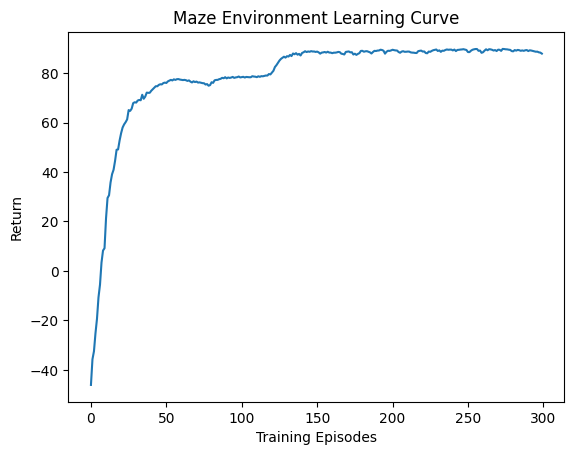

In [13]:
plt.plot(jnp.stack(returns))
plt.xlabel("Training Episodes")
plt.ylabel("Return")
plt.title("Maze Environment Learning Curve")

## Check the reward maps

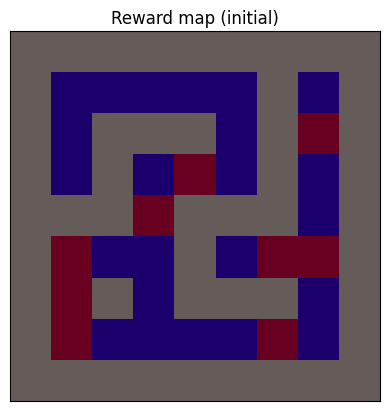

In [14]:
plt.imshow(env.world)
plt.imshow(env.reward_map_init, alpha=0.6, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.title("Reward map (initial)")
plt.show()

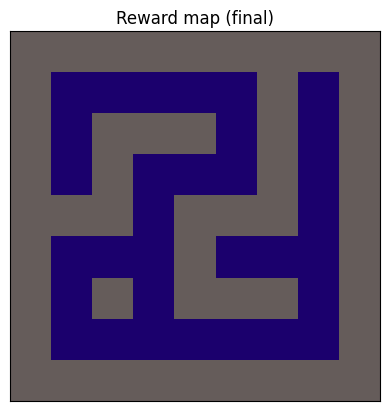

In [15]:
plt.imshow(env.world)
plt.imshow(env.reward_maps[-1], alpha=0.6, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.title("Reward map (final)")
plt.show()

## Saving and Loading the trained model

In [16]:
# Import necessary libraries for serialization
import flax.serialization as serialization

# Function to save the model
def save_model(state, filename):
    params = serialization.to_bytes(state.params)
    with open(filename, 'wb') as f:
        f.write(params)

# Function to load the model
def load_model(state, filename):
    with open(filename, 'rb') as f:
        params = serialization.from_bytes(state.params, f.read())
    return state.replace(params=params)

# Save the trained model
save_model(trained_state, 'trained_model.msgpack')


# Load the trained model
loaded_state = load_model(state, 'trained_model.msgpack')


## Evaluate

In [17]:
# Function to evaluate the model
def evaluate(env, state, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state_np = np.array(env.reset()).reshape(env.batch_size, -1)  # Flatten the initial state
        done = jnp.zeros(env.batch_size, dtype=bool)
        episode_reward = jnp.zeros(env.batch_size)

        while not jnp.all(done):
            key = jax.random.PRNGKey(random.randint(0, int(1e9)))
            action = select_action(state.params, jnp.array(state_np), key)
            action = jnp.array(action)

            next_state, reward, done = env.step(action)
            next_state = next_state.reshape(env.batch_size, -1)  # Flatten the next state

            state_np = np.array(next_state)
            episode_reward += reward

        total_rewards.append(jnp.mean(episode_reward))

    average_reward = np.mean(total_rewards)
    print(f'Average reward over {num_episodes} episodes: {average_reward}')
    return average_reward

# Evaluate the loaded model
_ = evaluate(env, loaded_state, num_episodes=10)

Average reward over 10 episodes: 87.6469955444336


# Additional things to try

- Try various other possible reward functions. 
- Use an end condition based on a reward threshold. Do it for a small maze
- Try changing the number of treasure chests. Does this have an effect on performance?
- Try changing the neural network structure